<a href="https://colab.research.google.com/github/JYHaw/Machine-Learning-Cryptanalysis-of-a-Quantum-Random-Number-Generator/blob/master/GPU_ML_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Step 1: Import packages. For faster computation, go to Runtime -> change runtime type and select "GPU".


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
import tensorflow as tf

In [5]:
from tensorflow.python.keras.layers import Input, Dense, Activation, Dropout, MaxPooling1D, Flatten, LSTM, Convolution1D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.utils.data_utils import get_file
from timeit import default_timer as timer 
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as scs
import random
import sys
import os
import glob



Step 2: Generate pseudo-random numbers with a congruential random number generator.
In this tutorial, we will use a short period of M=2^10, data length of 10000 (8000 for training, 2000 for testing) as demonstration


In [16]:
m_=10

def rngint(nbit=8):
    return int(rng()*(2**nbit))

def rng(m=2**m_, a=1103515245, c=12345):
    rng.current = (a*rng.current + c) % m
    return float(rng.current)/m

# setting the seed
rng.current = 12

data = np.array([rngint() for i in range(10000)])
data.tofile('CRNG_10k.bin')
print (data.shape)
print (data[:10])

(10000,)
[ 85 218  22  62 116  13 205  41 131 112]


Step 3: Set the input parameters. Let us start with a step size of 20 for faster training


In [17]:
#user-input variables

alldata = []
filenames = ['./CRNG_10k.bin']#Specify the directory + filename of the file to be trained and tested
weightname ='CRNG_10k' #Specify the name to call this set of data

# Length of input. Treating each input that consists of 100 "words" as a "sentence".
maxlen = 100 #Default is 100
# Distance between 2 consecutive "sentences"
step = 20 #Default is 3, can be increased to speed up the training. The smaller the step, the higher the accurancy

#Batch the data to relief hardware requirements. 
#Change this to smaller value if there is memory issue, or for validation. 
#The user can increase this (up to 1000000) if user's hardware permits. 
new_size = 1000

Data:CRNG_10k
Mean= 127.658
Standard Deviation= 73.82188724219938
Max-probability 0.004


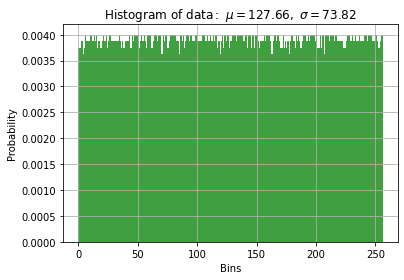

(10000,)


In [18]:
print('Data:'+weightname)

for filename in filenames:
    data = np.fromfile(filename, dtype='<i8')  
    alldata.append(data[:10000])

data=data[:8000]    
mu, sigma = np.mean(data), np.std(data)
#print('Mean='(mu),'Standard Deviation=' len(sigma))
print('Mean=',mu)
print('Standard Deviation=',sigma)

# the histogram of the data
n, bins, patches = plt.hist(data, list(range(np.min(data),np.max(data)+2)), density=1, facecolor='green', alpha=0.75)
print('Max-probability',max(n))

plt.xlabel('Bins')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of \ data:}\ \mu=%.2f,\ \sigma=%.2f$' % (mu,sigma))
plt.grid(True)

plt.show()

del data  #delete data

alldata = np.concatenate(alldata)    
print(alldata.shape)

In [19]:
text = alldata[:8000]
test1 = alldata[8000:9000]
test2 = alldata[9000:10000]
text = list(text)
test1 = list(test1)
test2 = list(test2)
text = map(str,text)
test1 = map(str,test1)
test2 = map(str,test2)
text_list = list(text)
test1_list = list(test1)
test2_list = list(test2)

del text
del test1
del test2

print(len(text_list), len(test1_list), len(test2_list))

8000 1000 1000




Step 4: Preparing the data for ML


In [20]:
# Treating each number as a "word". Creating a dictionary.
alldata = alldata.astype(np.str)
chars = sorted(list(set(alldata)))

print(chars)
del alldata
print('Total words:', len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '227', '228', '22

In [21]:
sentences = []
next_chars = []
for i in range(0, len(text_list) - maxlen, step):
    sentences.append(text_list[i: (i + maxlen)])
    next_chars.append(text_list[(i + maxlen)])
print('nb sequences:', len(sentences))


print('Start vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):        
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done vectorization!')

nb sequences: 395
Start vectorization...
Done vectorization!




Step 5: Build model and train the data


In [22]:
# build the RCNN model
print('Build model...')
model = Sequential()
model.add(Convolution1D(filters=64, kernel_size=9, padding='same', activation='relu', input_shape=(maxlen, len(chars))))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.0005), metrics=['accuracy'])
print(model.summary())
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
weight ='weights_'+weightname+'.hdf5'
print(weight)
monitoring = ModelCheckpoint(weight, monitor='val_loss', verbose=1, save_best_only=True)

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 64)           147520    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256) 

In [23]:
model.fit(X, y, epochs=50, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping,monitoring])
model.load_weights(weight)

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 5.5511 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 5.53948, saving model to weights_CRNG_10k.hdf5
3/3 [==============================] - 1s 499ms/step - loss: 5.5511 - accuracy: 0.0000e+00 - val_loss: 5.5395 - val_accuracy: 0.0253
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 5.5345 - accuracy: 0.0285
Epoch 00002: val_loss improved from 5.53948 to 5.53379, saving model to weights_CRNG_10k.hdf5
3/3 [==============================] - 0s 155ms/step - loss: 5.5345 - accuracy: 0.0285 - val_loss: 5.5338 - val_accuracy: 0.0127
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 5.5250 - accuracy: 0.0316
Epoch 00003: val_loss improved from 5.53379 to 5.53101, saving model to weights_CRNG_10k.hdf5
3/3 [==============================] - 0s 161ms/step - loss: 5.5250 - accuracy: 0.0316 - val_loss: 5.5310 - val_accuracy: 0.0000e+00
Epoch 4/50
3/3 [==============================]



Step 6: Perform the test for ML


In [24]:
tests = [test1_list,test2_list]
del test1_list
del test2_list
average = 0
start = timer()
for test in tests:
    n_batch = int(len(test)/new_size)
    for ib in range(n_batch):
        test_ = test[ib*new_size:(ib+1)*new_size]
    
        maxlen = 100
        step = 1
        sentences = []
        next_chars = []
        for i in range(0, len(test_) - maxlen, step):
            sentences.append(test_[i: (i + maxlen)])
            next_chars.append(test_[(i + maxlen)])
        print('nb sequences:', len(sentences))

        print('Vectorization...')
        Xt = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
        yt = np.zeros((len(sentences), len(chars)), dtype=np.bool)
        for i, sentence in enumerate(sentences):

            for t, char in enumerate(sentence):        
                Xt[i, t, char_indices[char]] = 1       
            yt[i, char_indices[next_chars[i]]] = 1
        n_true = 0
        diversity = 1
        for i,x in enumerate(Xt):
            if i % 100000 == 0:
                print ("Processed %d %d" % (i,n_true))
            x = x.reshape(1,maxlen,-1)
            preds = model.predict(x, verbose=0)[0]
            next_index = np.argmax(preds)      
            next_char = indices_char[next_index]
            if next_char == indices_char[np.argmax(yt[i])]:
                n_true += 1
        print ("%d_%d_%.5f" % (n_true,yt.shape[0],(float(n_true)/yt.shape[0])))
        average = average + (float(n_true)/yt.shape[0])
print("Time taken: %.5f hours, P_ML = %.5f, P_8bit= %.5f" % (float(timer()-start)/3600, average/(2*n_batch),1/2**8))

nb sequences: 900
Vectorization...
Processed 0 0
50_900_0.05556
nb sequences: 900
Vectorization...
Processed 0 0
50_900_0.05556
Time taken: 0.02477 hours, P_ML = 0.05556, P_8bit= 0.00391


We see that the machine learning guessing can outperform the expected probability of 1/2^8 (~0.0039) for an 8-bit distribution. 
Now re-run the whole code again with step size of 3, and observe the outcome.

Once you have completed this, you are welcome to check out the full version of our codes on the github: https://github.com/NeuroSyd/Machine-Learning-Cryptanalysis-of-a-Quantum-Random-Number-Generator

In particular, under the "Benchmark" folder, you can evaluate your binary data, where the first 80,000,000 bit will be trained and tested in 8-bit format.
Of course, unlike the tutorial here will smaller size and lesser test sets, the whole test will take much longer time, depending on the specification of your hardware.